<h2 align=center> Toxic Comments Classification using 1D CNN with Keras</h2>

### Task 1: Import Packages and Functions

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from sklearn.model_selection import train_test_split
print(tf.__version__)

2.2.0


### Task 2: Load and Explore Data

In [3]:
# Load data
train_df = pd.read_csv('train.csv').fillna(' ')
train_df.sample(10, random_state=1)

,comment_text,toxic
24915,"YOU ARE A FAT, GEEKY PRICK WHO HAS NOTHING TO ...",1
75819,Agent X2: Basically thanks - with a 'little' m...,0
53891,Why are my posts being deleted? \n\nI have tri...,0
154159,"""\n\n Controlled Demolitions and Common Sense ...",0
13040,I do not understand your reply. //Blaxthos ( ...,0
123190,Is this the bizarro world? Removing content is...,0
33626,"Well, WP:RS says that articles should use reli...",0
1150,Oh hear me go someone removes all my pages i g...,0
48633,can't believe this article was deleted\nI'm su...,0
42817,"""\n\n Comments on GamerGate Workshop page \n\n...",0


In [4]:
x = train_df['comment_text'].values
print(x)


["Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"
 "D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)"
 "Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info."
 ...
 'Spitzer \n\nUmm, theres no actual article for prostitution ring.  - Crunch Captain.'
 'And it looks like it was actually you who put on the speedy to have the first version deleted now that I look at it.'
 '"\nAnd ... I really don\'t think you understand.  I came here and my idea was bad right away.  What kind of community goes ""you have bad ideas"" go away, instead o

In [5]:
# View few toxic comments
train_df.loc[train_df['toxic'] == 1].sample(10, random_state=1)

,comment_text,toxic
116043,My page should be protected first so that wort...,1
143704,Oh so it's you who wants the considerable amou...,1
133763,I'll leave you alone when you levae me and my ...,1
118814,It's you who is doing original research by suc...,1
147953,other people's\nGosh you can't even speak Engl...,1
156998,Wow... \n\nYour just a fucking retard. Some of...,1
91219,"No, Assfuckers (has a nice ring to it D) use i...",1
43290,Complaint \n\nThis user rapes donkeys.,1
4671,Penis \n\nDid you sex with Grawp? H-A-6-6-E-P?...,1
24616,dear omni looser stop editing my crap then die,1


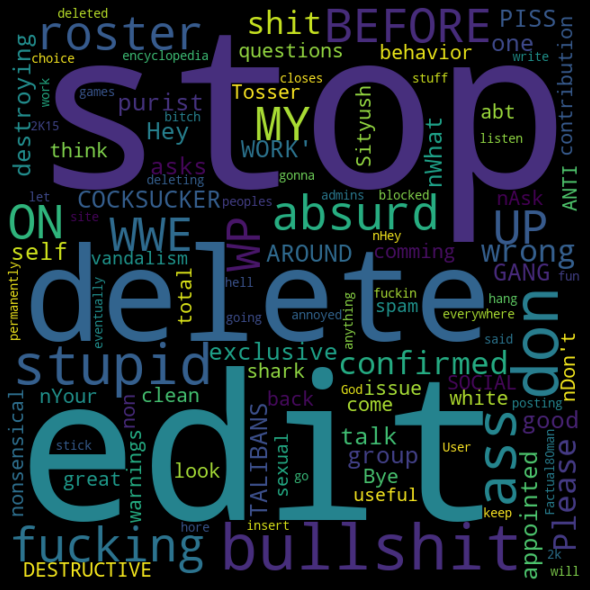

In [6]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
comments = train_df['comment_text'].loc[train_df['toxic']==1].values
wordcloud = WordCloud(
    width = 640,
    height = 640,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(comments))
fig = plt.figure(
    figsize = (12, 8),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [7]:
y = train_df['toxic'].values
print(y)

[0 0 0 ... 0 0 0]


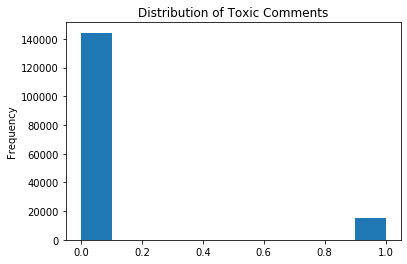

In [8]:
# Plot frequency of toxic comments
train_df['toxic'].plot(kind='hist', 
                       title='Distribution of Toxic Comments')

In [9]:
train_df['toxic'].value_counts()

0    144277
1     15294
Name: toxic, dtype: int64

### Task 3: Data Prep — Tokenize and Pad Text Data

In [10]:
# Most featured/used top 20000 words will be kept 
# and rest will be not used in our neural network training 
max_features = 20000
# maximum length a comment can have
# comments with less length will be
# padded to make them equal to max_text_length
max_text_length = 400

In [11]:
# Tokenize our text
# text.Tokenizer allows us to vectorize text by converting
# each text into sequence of integers 
# where each integer being the index in a dictionary
x_tokenizer = text.Tokenizer(max_features)
x_tokenizer.fit_on_texts(list(x))
x_tokenized = x_tokenizer.texts_to_sequences(x)

# pad to make length same
x_train_val = sequence.pad_sequences(x_tokenized, maxlen=max_text_length)

### Task 4: Prepare Embedding Matrix with Pre-trained GloVe Embeddings

In [15]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip -q glove.6B.zip

embedding_dim = 100
embedding_index = dict()

f = open('glove.6B.100d.txt')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embedding_index[word] = coefs
f.close()
print(f'Found {len(embedding_index)} word vectors')

Found 400000 word vectors


In [19]:
embedding_matrix = np.zeros((max_features, embedding_dim))

for word, index in x_tokenizer.word_index.items():
    if index > max_features - 1:
        break
    else:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

### Task 5: Create the Embedding Layer

In [24]:
model = Sequential()
model.add(Embedding(max_features,
                   embedding_dim,
                   embeddings_initializer=tf.keras.initializers.Constant(
                   embedding_matrix), trainable=False))
model.add(Dropout(0.2))

### Task 6: Build the Model

In [25]:
filters = 250
kernel_size = 3
hidden_dims = 250

In [27]:
model.add(Conv1D(filters, kernel_size, padding='valid'))
model.add(MaxPooling1D())

model.add(Conv1D(filters, 5, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())

model.add(Dense(hidden_dims, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         2000000   
_________________________________________________________________
dropout (Dropout)            (None, None, 100)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 250)         75250     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 250)         187750    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 250)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 250)         312750    
_________________________________________________________________
global_max_pooling1d (Global (None, 250)              

In [29]:
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

### Task 7: Train Model

In [30]:
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y, 
                                                 test_size=0.15, random_state=1)

In [31]:
batch_size = 32
epochs = 3

model.fit(x_train, y_train, batch_size = batch_size,
         epochs = 3,
         validation_data = (x_val, y_val))

Epoch 1/3
4239/4239 [==============================] - 135s 32ms/step - loss: 0.1652 - accuracy: 0.9412 - val_loss: 0.1447 - val_accuracy: 0.9463
Epoch 2/3
4239/4239 [==============================] - 136s 32ms/step - loss: 0.1460 - accuracy: 0.9471 - val_loss: 0.1253 - val_accuracy: 0.9541
Epoch 3/3
4239/4239 [==============================] - 135s 32ms/step - loss: 0.1414 - accuracy: 0.9486 - val_loss: 0.1407 - val_accuracy: 0.9504


### Task 8: Evaluate Model

In [32]:
test_df = pd.read_csv('test.csv')

In [33]:
x_test = test_df['comment_text'].values

In [36]:
x_test_tokenized = x_tokenizer.texts_to_sequences(x_test)
x_testing = sequence.pad_sequences(x_test_tokenized, maxlen=max_text_length)

In [37]:
y_testing = model.predict(x_testing, verbose=1, batch_size=32)

4787/4787 [==============================] - 54s 11ms/step


In [38]:
y_testing.shape

(153164, 1)

In [39]:
y_testing[0]

array([0.9997893], dtype=float32)

In [43]:
test_df['Toxic'] = ['not toxic' if x<0.5 else 'toxic' for x in y_testing ]
test_df[['comment_text','Toxic']].head(20)

,comment_text,Toxic
0,Yo bitch Ja Rule is more succesful then you'll...,toxic
1,== From RfC == \n\n The title is fine as it is...,not toxic
2,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",not toxic
3,":If you have a look back at the source, the in...",not toxic
4,I don't anonymously edit articles at all.,not toxic
5,Thank you for understanding. I think very high...,not toxic
6,Please do not add nonsense to Wikipedia. Such ...,not toxic
7,:Dear god this site is horrible.,toxic
8,""" \n Only a fool can believe in such numbers. ...",toxic
9,== Double Redirects == \n\n When fixing double...,not toxic
